## 0. Import Libraries

In [128]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
import metpy.calc as mpcalc
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy, vertcross
from netCDF4 import Dataset
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)
from metpy.units import units
from scipy.constants import g

import warnings
warnings.filterwarnings('ignore')

## 1. Open Data

In [135]:
def open_data(run_data, variable):
    """
    Opens relevant xarray wrf data
    """
    
    # data path
    data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

    # open data
    dt = xr.open_mfdataset(data_path,
                           concat_dim='ens')

    # instead of 201 grid we want 200 grid in each direction
    dt_clip = dt.isel(south_north=slice(0,200),
                 west_east=slice(0,200))
    
    # change var name
    if variable == 'spehum':
        dt_clip = dt_clip.rename({'__xarray_dataarray_variable__':variable})
    
    return dt_clip

def modify_ens_names(dt):
    
    dt['ens'] = ['LIN_nourban', 'LIN_urban',
               'THOMPSON_nourban', 'THOMPSON_urban',
               'WSM6_nourban', 'WSM6_urban']
    
    return dt

In [136]:
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

### 1.1 ERA5

In [137]:
run_data = 'era5'
variables = ['spehum', 'ua', 'va', 'PRESSURE']

dt_era5 = {}
for v in variables:
    
    dt = open_data(run_data, v)
    dt = modify_ens_names(dt)
    dt_era5[v] = dt

### 1.2 GFS

In [138]:
run_data = 'gfs'

dt_gfs = {}
for v in variables:
    
    dt = open_data(run_data, v)
    dt = modify_ens_names(dt)
    dt_gfs[v] = dt

## 2. Calculate IVP

In [139]:
def create_levels(dt, press, levels):
    
    dts = []
    for l in levels:
        dt_lev = interplevel(dt, press, l)
        dts.append(dt_lev)
    return xr.concat(dts, dim='level')

In [198]:
def calculate_ivt(dt_qu, dt_qv, levels):
    """
    long version of dt.integrate(coord = 'level')
    """
    
    ivtx = 0
    ivty = 0

    for i in range(len(levels)-1):

        delta = (levels[i+1]-levels[i]) * 1000 * units('kg*m**-1*s**-2') # hPa to Pa
        qu_delta = ((dt_qu.sel(level=levels[i]) + dt_qu.sel(level=levels[i+1])) / 2) * delta
        qv_delta = ((dt_qv.sel(level=levels[i]) + dt_qv.sel(level=levels[i+1])) / 2) * delta

        ivtx += qu_delta
        ivty += qv_delta   
        
    return (-1/g*units('m/s**2'))*ivtx, (-1/g*units('m/s**2'))*ivty

In [197]:
1000 * units('kg*m**-1*s**-2')

1000.0 <Unit('kilogram / meter / second ** 2')>

In [160]:
# general parameters
ens_members = ['LIN_nourban', 'LIN_urban',
               'THOMPSON_nourban', 'THOMPSON_urban',
               'WSM6_nourban', 'WSM6_urban']
pr_var = 'PRESSURE'
levels = [925, 850, 700]

### 2.1 ERA5

In [146]:
dt_var_era5 = {}

for v in ['spehum', 'ua', 'va']:
    
    dt_ens = []
    for ens in ens_members:
        
        dt_ = dt_era5[v][v].sel(ens = ens)
        press_ = dt_era5[pr_var][pr_var].sel(ens = ens)
        dt_lev = create_levels(dt_, press_, levels)
        dt_ens.append(dt_lev)
        
    dt_var_era5[v] = xr.concat(dt_ens, dim='ens')

In [202]:
qu = (dt_var_era5['spehum']*units('kg/kg') * dt_var_era5['ua'] * units('m/s'))
qv = (dt_var_era5['spehum']*units('kg/kg') * dt_var_era5['va'] * units('m/s'))

ivtx_era5, ivty_era5 = calculate_ivt(qu, qv, levels)

In [193]:
np.sqrt(3*units('kg**2'))

1.7320508075688772 <Unit('kilogram')>

In [208]:
qu.integrate(coord='level')

<xarray.DataArray (ens: 6, time: 6, south_north: 200, west_east: 200)>
<Quantity([[[[  9.05952584   8.5945786    8.06368198 ...  -1.33631558
     -1.1555803   -1.20739094]
   [  8.9334866    8.35139668   8.00130274 ...  -1.41661065
     -1.23604971  -1.47338875]
   [  8.66993722   8.17737272   7.8174457  ...  -1.34907898
     -1.23619933  -1.55530425]
   ...
   [ 16.79039374  16.43011523  16.35306124 ...  28.73930521
     28.70039865  28.65865789]
   [ 16.98545935  16.57514423  16.48616809 ...  28.63704041
     28.60035785  28.56232636]
   [ 17.14787353  16.68205569  16.63137926 ...  28.52522805
     28.49583998  28.46354842]]

  [[  3.6618964    4.83585773   6.20811023 ...  -3.56011761
     -3.68638267  -3.73838847]
   [  3.67028425   4.50047697   5.82019798 ...  -3.30906215
     -3.35253517  -3.42197071]
   [  4.01850182   4.56977072   5.33686895 ...  -3.0367974
     -3.00817285  -3.11144795]
...
   [ 15.29294942  15.20968582  15.15672058 ...  28.69708836
     28.77639681  28.8590122 ]
   [ 15.33198953  15.21892995  15.14404323 ...  28.69077176
     28.76458615  28.83471586]
   [ 15.42950291  15.27662538  15.12524262 ...  28.68330516
     28.75358574  28.81216854]]

  [[  8.62329695   8.57024789   8.45564716 ... -16.82983674
    -18.05930156 -19.4091551 ]
   [  8.99856258   9.10070781   8.97587892 ... -17.32017472
    -18.06512084 -19.21031512]
   [  9.29499194   9.43311118   9.15008727 ... -16.77093487
    -17.16192048 -17.79979672]
   ...
   [ 15.95859546  15.73209185  15.30169006 ...  27.43768394
     27.47044042  27.52102241]
   [ 15.974411    15.7243615   15.1768472  ...  27.4169337
     27.44916044  27.49338448]
   [ 15.8118479   15.55426754  15.10092057 ...  27.38747187
     27.4215281   27.45929807]]]], 'meter / second')>
Coordinates:
  * time         (time) datetime64[ns] 2017-07-18T07:00:00 ... 2017-07-18T12:...
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
    XLONG        (south_north, west_east) float32 27.69 27.7 ... 30.05 30.06
    XLAT         (south_north, west_east) float32 40.08 40.08 ... 41.88 41.88
    XTIME        (ens, time) float32 1.86e+03 1.92e+03 ... 3.54e+03 3.6e+03
    Time         (time) datetime64[ns] 2017-07-18T07:00:00 ... 2017-07-18T12:...
  * ens          (ens) <U16 'LIN_nourban' 'LIN_urban' ... 'WSM6_urban'

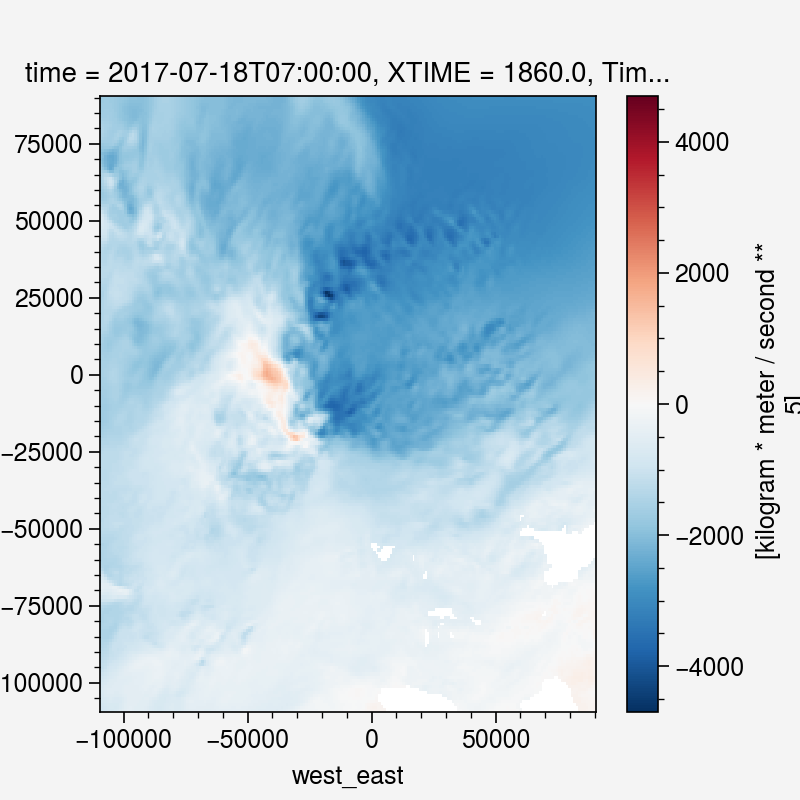

In [205]:
ivtx_era5[0][0].plot()

In [179]:
qu

<xarray.DataArray (ens: 6, level: 3, time: 6, south_north: 200, west_east: 200)>
<Quantity([[[[[-5.42234704e-02 -5.51583730e-02 -5.68119772e-02 ...
      3.06430808e-03  6.98610954e-03  9.95508023e-03]
    [-5.46626411e-02 -5.50752208e-02 -5.64082339e-02 ...
      8.16934928e-03  1.12816868e-02  1.31041203e-02]
    [-5.62243201e-02 -5.69695123e-02 -5.81519566e-02 ...
      1.02037201e-02  1.30456965e-02  1.51044792e-02]
    ...
    [ 7.56557332e-03  7.56730372e-03  2.61965347e-03 ...
     -1.42161280e-01 -1.41874626e-01 -1.41660586e-01]
    [ 3.72796599e-03  5.02288435e-03 -7.73852400e-04 ...
     -1.41921684e-01 -1.41553134e-01 -1.41265616e-01]
    [-3.99134401e-03 -6.68762834e-04 -5.56587754e-03 ...
     -1.41834214e-01 -1.41475633e-01 -1.41209632e-01]]

   [[-4.70388159e-02 -4.17032167e-02 -3.57111096e-02 ...
     -4.33018990e-03 -2.43961043e-03 -1.59874849e-03]
    [-5.32955490e-02 -4.59824987e-02 -4.29508910e-02 ...
     -6.03852468e-03 -3.25348647e-03 -1.54958956e-03]
    [-6.06293790e-02 -5.50484434e-02 -5.05399816e-02 ...
     -5.60680404e-03 -2.93845986e-03 -1.08616555e-03]
...
    [-4.51734327e-02 -4.75294590e-02 -5.07075861e-02 ...
     -6.53961673e-02 -6.50333315e-02 -6.46362305e-02]
    [-4.61996868e-02 -4.84140851e-02 -5.12626767e-02 ...
     -6.56910092e-02 -6.53709397e-02 -6.49754256e-02]
    [-4.71446253e-02 -4.90058251e-02 -5.12199365e-02 ...
     -6.61489218e-02 -6.58466816e-02 -6.54785559e-02]]

   [[ 9.81122814e-03  9.74584185e-03  9.51904152e-03 ...
      4.47665043e-02  5.03301397e-02  5.50731421e-02]
    [ 1.03253406e-02  1.03386817e-02  9.79299191e-03 ...
      3.63108851e-02  3.87080498e-02  4.57629748e-02]
    [ 1.02935396e-02  1.02231717e-02  1.04488423e-02 ...
      2.59307623e-02  2.72193681e-02  3.14788371e-02]
    ...
    [-5.42108528e-02 -5.57365976e-02 -5.57383709e-02 ...
     -5.80454767e-02 -5.74358776e-02 -5.67855909e-02]
    [-5.48327081e-02 -5.63300736e-02 -5.59080802e-02 ...
     -5.90761900e-02 -5.84695041e-02 -5.77585213e-02]
    [-5.49093261e-02 -5.60912415e-02 -5.55888414e-02 ...
     -6.00851737e-02 -5.94399907e-02 -5.85944504e-02]]]]], 'gram * meter / kilogram / second')>
Coordinates:
  * time         (time) datetime64[ns] 2017-07-18T07:00:00 ... 2017-07-18T12:...
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
    XLONG        (south_north, west_east) float32 27.69 27.7 ... 30.05 30.06
    XLAT         (south_north, west_east) float32 40.08 40.08 ... 41.88 41.88
    XTIME        (ens, time) float32 1.86e+03 1.92e+03 ... 3.54e+03 3.6e+03
    Time         (time) datetime64[ns] 2017-07-18T07:00:00 ... 2017-07-18T12:...
  * ens          (ens) <U16 'LIN_nourban' 'LIN_urban' ... 'WSM6_urban'
  * level        (level) int64 925 850 700

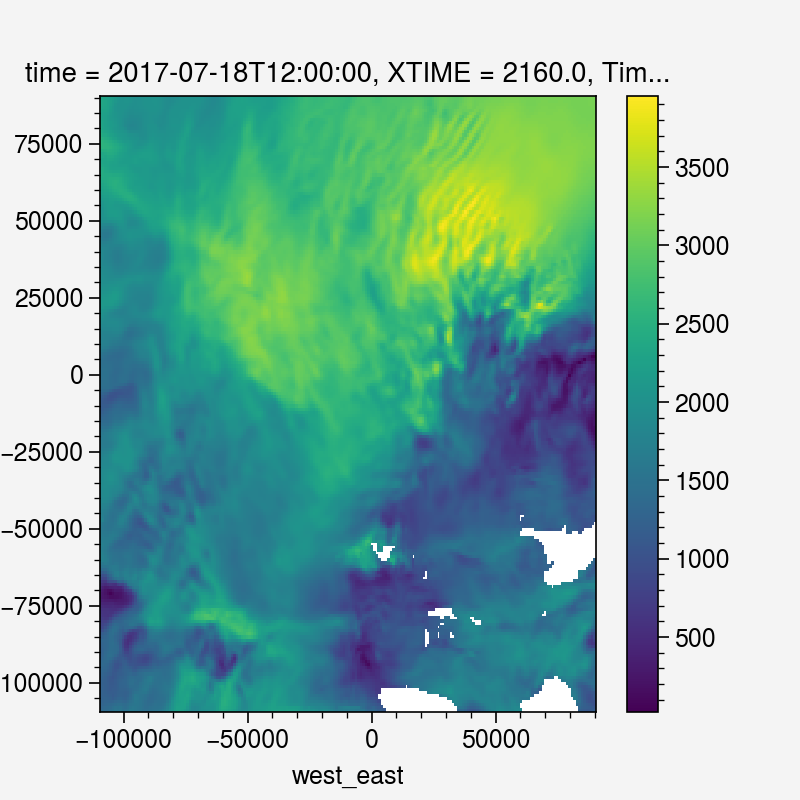

In [166]:
np.sqrt((ivtx_era5**2 + ivty_era5**2))[0][-1].plot()

In [144]:
ivtx_era5

<xarray.DataArray (ens: 6, time: 6, south_north: 200, west_east: 200)>
array([[[[-1.0422297e+00,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-1.0375892e+00,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-1.0229475e+00, -1.0251621e+00,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
          -3.9513671e+00, -3.9448800e+00, -3.9383616e+00],
         [           nan,            nan,            nan, ...,
          -3.9388435e+00, -3.9328532e+00, -3.9273233e+00],
         [           nan,            nan,            nan, ...,
          -3.9256530e+00, -3.9203005e+00, -3.9145448e+00]],

        [[-3.8591850e-01,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-4.3054846e-01,            nan,            nan, ...,
                     nan,            nan,            nan],
         [-5.2126932e-01, -5.4516363e-01,            nan, ...,
                     nan,            nan,            nan],
...
          -3.9239736e+00, -3.9390781e+00, -3.9541752e+00],
         [           nan,            nan,            nan, ...,
          -3.9224796e+00, -3.9366870e+00, -3.9496808e+00],
         [           nan,            nan,            nan, ...,
          -3.9203343e+00, -3.9340832e+00, -3.9446564e+00]],

        [[-1.1176395e+00, -1.1013360e+00,            nan, ...,
                     nan,            nan,            nan],
         [-1.1780088e+00, -1.1699505e+00,            nan, ...,
                     nan,            nan,            nan],
         [-1.2215941e+00, -1.2387700e+00,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
          -3.7412386e+00, -3.7485819e+00, -3.7577198e+00],
         [           nan,            nan,            nan, ...,
          -3.7372990e+00, -3.7447963e+00, -3.7535584e+00],
         [           nan,            nan,            nan, ...,
          -3.7323961e+00, -3.7402234e+00, -3.7500212e+00]]]],
      dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2017-07-18T07:00:00 ... 2017-07-18T12:...
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
    XLONG        (south_north, west_east) float32 27.69 27.7 ... 30.05 30.06
    XLAT         (south_north, west_east) float32 40.08 40.08 ... 41.88 41.88
    XTIME        (ens, time) float32 1.86e+03 1.92e+03 ... 3.54e+03 3.6e+03
    Time         (time) datetime64[ns] 2017-07-18T07:00:00 ... 2017-07-18T12:...
  * ens          (ens) <U16 'LIN_nourban' 'LIN_urban' ... 'WSM6_urban'

In [ ]:
def calculate_ivtx():
    
    

In [19]:
def calculate_QU(dt, ens):
    
    qu = dt['spehum']['spehum'].sel(ens=ens) *\
            dt['ua']['ua'].sel(ens=ens)
    
    qv = dt['spehum']['spehum'].sel(ens=ens) *\
            dt['va']['va'].sel(ens=ens)
    
    return qu, qv

In [ ]:
def calculate IVP(dt, run_type, lev_from, lev_to, variables):
    """
    Calculates IVP between lev_from and lev_to
    """
    
    # interpolate to various levels
    ens_members = ['LIN_nourban', 'LIN_urban',
               'THOMPSON_nourban', 'THOMPSON_urban',
               'WSM6_nourban', 'WSM6_urban']
    
    for e in ens_members:
        qu, qv = calculate_QU(dt, e)
    
        for l in [1000, ]

# aşağısı önemli

In [61]:
def create_levels(dt, press):
    
    levels = [1000, 925, 850, 700]
    
    dts = []
    for l in levels:
        dt_lev = interplevel(dt, press, l)
        dts.append(dt_lev)
    return xr.concat(dts, dim='level')

In [112]:
def calculate_ivt(dt_qu, dt_qv, levels):
    """
    long version of dt.integrate(coord = 'level')
    """
    
    ivtx = 0
    ivty = 0

    for i in range(len(levels)-1):

        delta = levels[i+1]-levels[i]
        qu_delta = ((dt_qu.sel(level=levels[i]) + dt_qu.sel(level=levels[i+1])) / 2) * delta
        qv_delta = ((dt_qv.sel(level=levels[i]) + dt_qv.sel(level=levels[i+1])) / 2) * delta

        ivtx += qu_delta
        ivty += qv_delta   
        
    return ivtx, ivty

In [62]:
# general parameters
ens_members = ['LIN_nourban', 'LIN_urban',
               'THOMPSON_nourban', 'THOMPSON_urban',
               'WSM6_nourban', 'WSM6_urban']
pr_var = 'PRESSURE'

In [63]:
dt_var_era5 = {}

for v in ['spehum', 'ua', 'va']:
    
    dt_ens = []
    for ens in ens_members:
        
        dt_ = dt_era5[v][v].sel(ens = ens)
        press_ = dt_era5[pr_var][pr_var].sel(ens = ens)
        dt_lev = create_levels(dt_, press_)
        dt_ens.append(dt_lev)
        
    dt_var_era5[v] = xr.concat(dt_ens, dim='ens')

In [92]:
qu = (dt_var_era5['spehum'] * dt_var_era5['ua'])
qv = (dt_var_era5['spehum'] * dt_var_era5['va'])

In [113]:
levels = [1000, 925, 850, 700]
ivtx, ivty = calculate_ivt(qu, qv, levels)

In [85]:
((qu.sel(level=1000) + qu.sel(level=925)) / 2) * (1000-925)

<xarray.DataArray (ens: 6, time: 6, south_north: 200, west_east: 200)>
array([[[[ -1161.256   ,           nan,           nan, ...,
                    nan,           nan,           nan],
         [ -1241.7878  ,           nan,           nan, ...,
                    nan,           nan,           nan],
         [ -1361.7522  ,  -1876.034   ,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [          nan,           nan,           nan, ...,
          -10010.372   ,  -9985.661   ,  -9963.476   ],
         [          nan,           nan,           nan, ...,
           -9989.822   ,  -9967.754   ,  -9951.561   ],
         [          nan,           nan,           nan, ...,
           -9972.278   ,  -9949.178   ,  -9925.028   ]],

        [[  -122.67151 ,           nan,           nan, ...,
                    nan,           nan,           nan],
         [  -551.954   ,           nan,           nan, ...,
                    nan,           nan,           nan],
         [ -1093.4038  ,   -776.4582  ,           nan, ...,
                    nan,           nan,           nan],
...
         [          nan,           nan,           nan, ...,
           -9783.949   ,  -9852.767   ,  -9918.202   ],
         [          nan,           nan,           nan, ...,
           -9775.616   ,  -9841.125   ,  -9898.423   ],
         [          nan,           nan,           nan, ...,
           -9762.044   ,  -9826.593   ,  -9871.699   ]],

        [[ -2337.0034  ,  -2230.1692  ,           nan, ...,
                    nan,           nan,           nan],
         [ -2553.7576  ,  -2372.5874  ,           nan, ...,
                    nan,           nan,           nan],
         [ -2684.7537  ,  -2715.073   ,           nan, ...,
                    nan,           nan,           nan],
         ...,
         [          nan,           nan,           nan, ...,
           -9251.335   ,  -9290.593   ,  -9329.623   ],
         [          nan,           nan,           nan, ...,
           -9233.449   ,  -9274.748   ,  -9316.448   ],
         [          nan,           nan,           nan, ...,
           -9214.828   ,  -9257.536   ,  -9315.846   ]]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2017-07-18T07:00:00 ... 2017-07-18T12:...
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
    XLONG        (south_north, west_east) float32 27.69 27.7 ... 30.05 30.06
    XLAT         (south_north, west_east) float32 40.08 40.08 ... 41.88 41.88
    XTIME        (ens, time) float32 1.86e+03 1.92e+03 ... 3.54e+03 3.6e+03
    Time         (time) datetime64[ns] 2017-07-18T07:00:00 ... 2017-07-18T12:...
  * ens          (ens) <U16 'LIN_nourban' 'LIN_urban' ... 'WSM6_urban'

In [16]:
dt_gfs['spehum']['spehum']

<xarray.DataArray 'spehum' (ens: 6, time: 6, bottom_top: 60, south_north: 200, west_east: 200)>
dask.array<mul, shape=(6, 6, 60, 200, 200), dtype=float32, chunksize=(1, 6, 60, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2017-07-18T03:00:00 ... 2017-07-18T08:...
  * south_north  (south_north) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
  * west_east    (west_east) float64 -1.09e+05 -1.08e+05 ... 8.9e+04 9e+04
    XLONG        (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    XLAT         (south_north, west_east) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    XTIME        (time) float32 dask.array<chunksize=(6,), meta=np.ndarray>
    Time         (time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * ens          (ens) object 'LIN_nourban_td' ... 'WSM6_urban_td'
Dimensions without coordinates: bottom_top